In [367]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import datetime
import os

2018_01_17_17_40_17_cs-ssro
ivars: []
ivar:	0.0	retention:0.714 +- 0.038


<IPython.core.display.Javascript object>


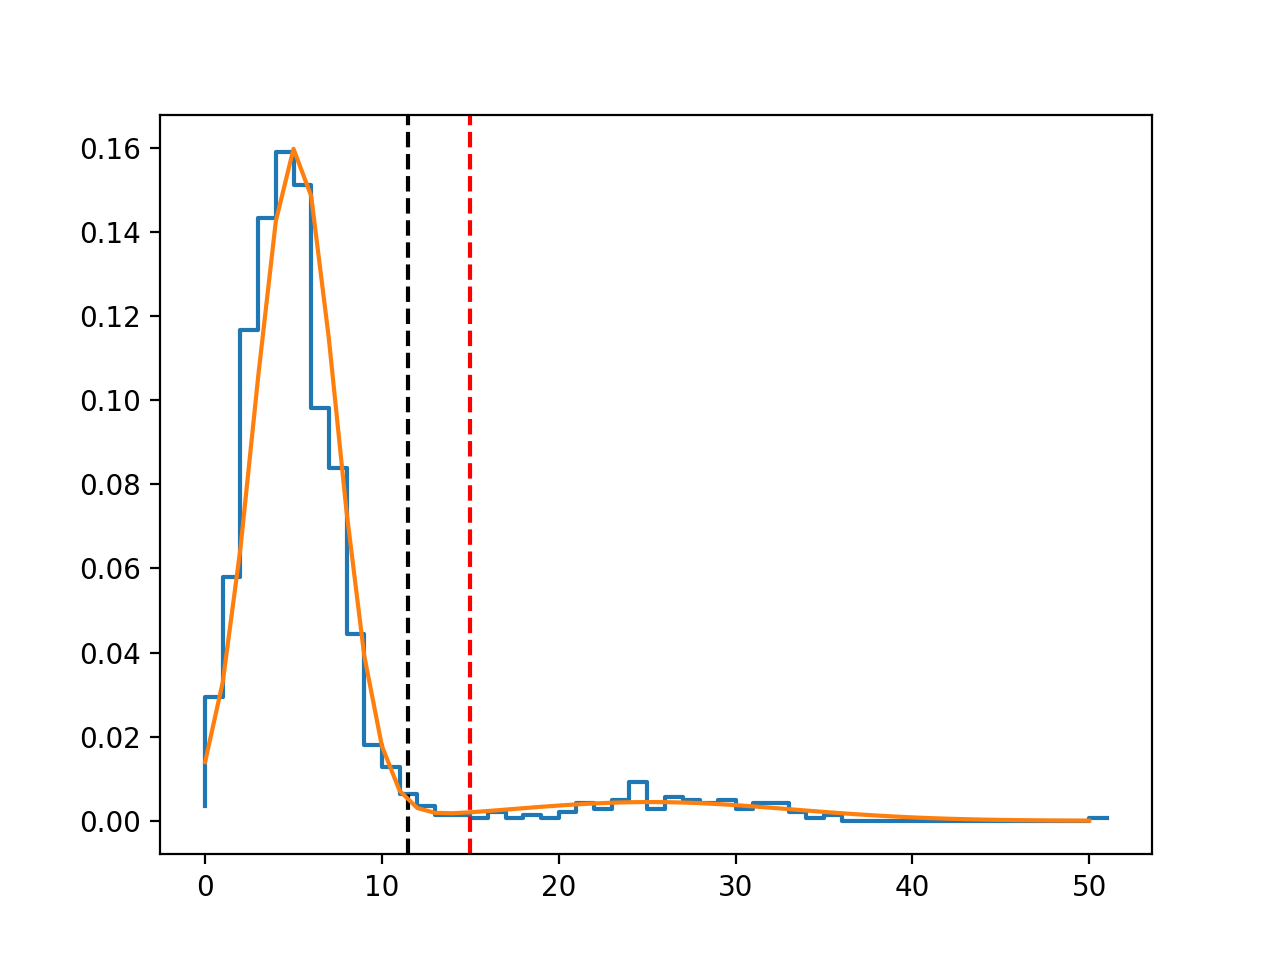

[11.466934307220168]
[  0.92535179   0.08984965   5.1075718   25.16742833   2.31158092
   8.03909316]
10.0299282672
3.92747421454


In [484]:
dp = '/home/ebert/jupyter-notebooks/FNode-data'
# exp_name = '2018_01_11_17_49_28_cs-readout-test'
exp_name = ''
if not exp_name:
    exp_date = datetime.datetime.now().strftime("%Y_%m_%d")
    search_path = os.path.join(dp, exp_date)
    exp_name = os.listdir(search_path)[-1]
    print exp_name
else:    
    exp_date = '_'.join(exp_name.split('_')[:3])
experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
print "ivars: {}".format(q.experiments[0]['variable_list'])
results = q.generate_thresholds()
cuts = [[15],[2]]
q.set_thresholds(cuts)
retention = q.apply_thresholds()
tbl_str = "ivar:\t{0}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))
q.save_experiment_data()

s=0
shift = 0
fig, ax = plt.subplots()
ax.step(results[s]['hist_x']+shift, results[s]['hist_y'])
xs = np.arange(max(results[0]['hist_x']))

for i, xc in enumerate(results[s]['cuts']):
    plt.axvline(x=xc, color='k', linestyle='--')
    plt.axvline(x=cuts[s][i], color='r', linestyle='--')

ax.plot(xs, qdp.dblgauss(xs, *results[s]['fit_params']))
print(results[s]['cuts'])
print results[s]['fit_params']
print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/2
print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/results[s]['fit_params'][2]

<IPython.core.display.Javascript object>


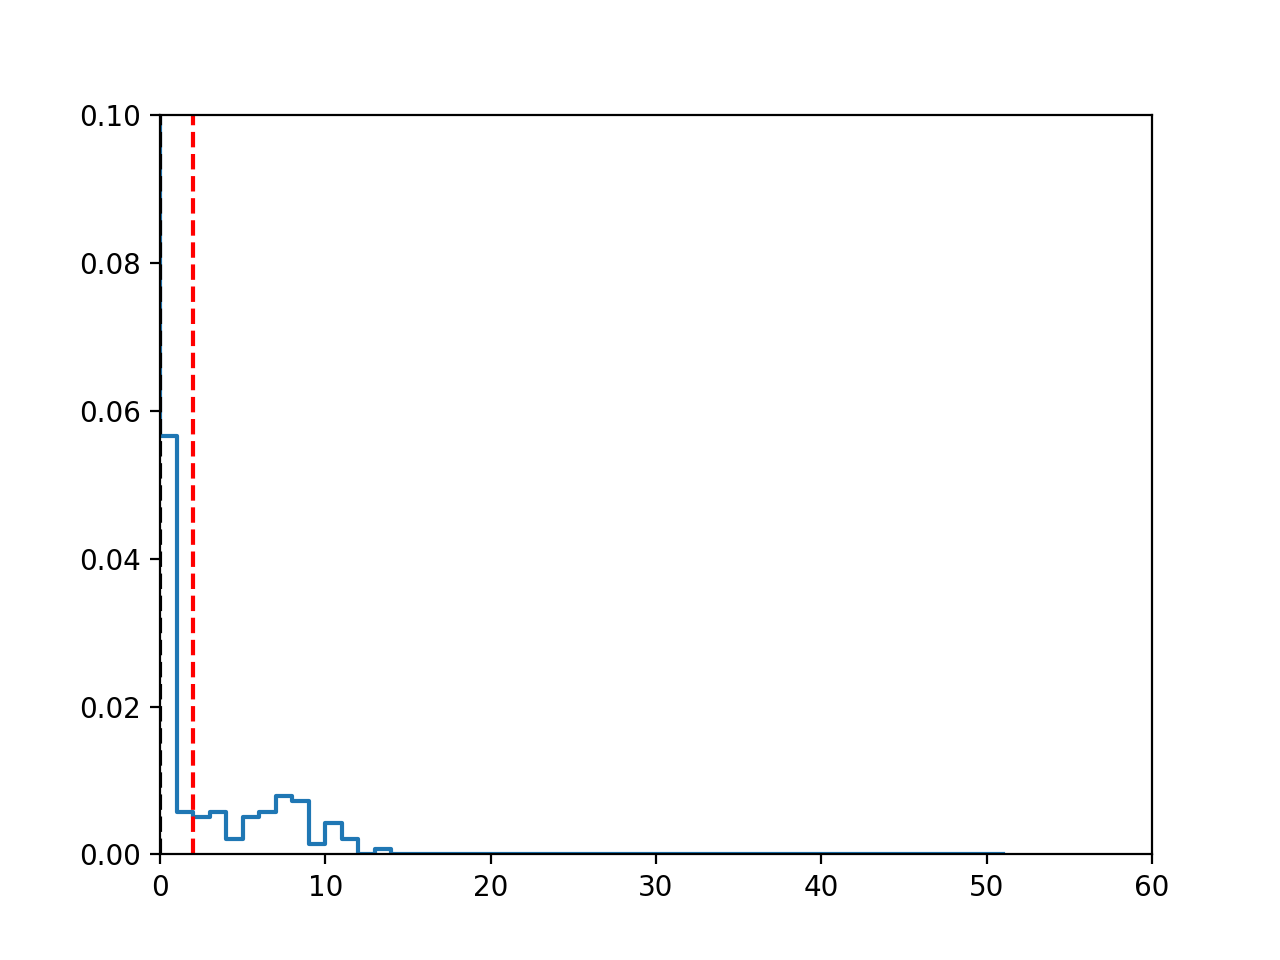

[-0.0]
[ 0.89038351  0.10961649  0.          3.75756534  0.          1.93844405]
0.939391333778


In [485]:
s=1
shift = 0
fig, ax = plt.subplots()
ax.step(results[s]['hist_x']+shift, results[s]['hist_y'])
xs = np.arange(max(results[s]['hist_x']))

for i, xc in enumerate(results[s]['cuts']):
    plt.axvline(x=xc, color='k', linestyle='--')
    plt.axvline(x=cuts[s][i], color='r', linestyle='--')

ax.plot(xs, qdp.dblgauss(xs+0.5, *results[s]['fit_params']))
ax.set_xlim(0, 60)
ax.set_ylim(0,0.1)
print(results[s]['cuts'])
print results[s]['fit_params']
print (results[s]['fit_params'][3]-results[s]['fit_params'][2])/4

<IPython.core.display.Javascript object>


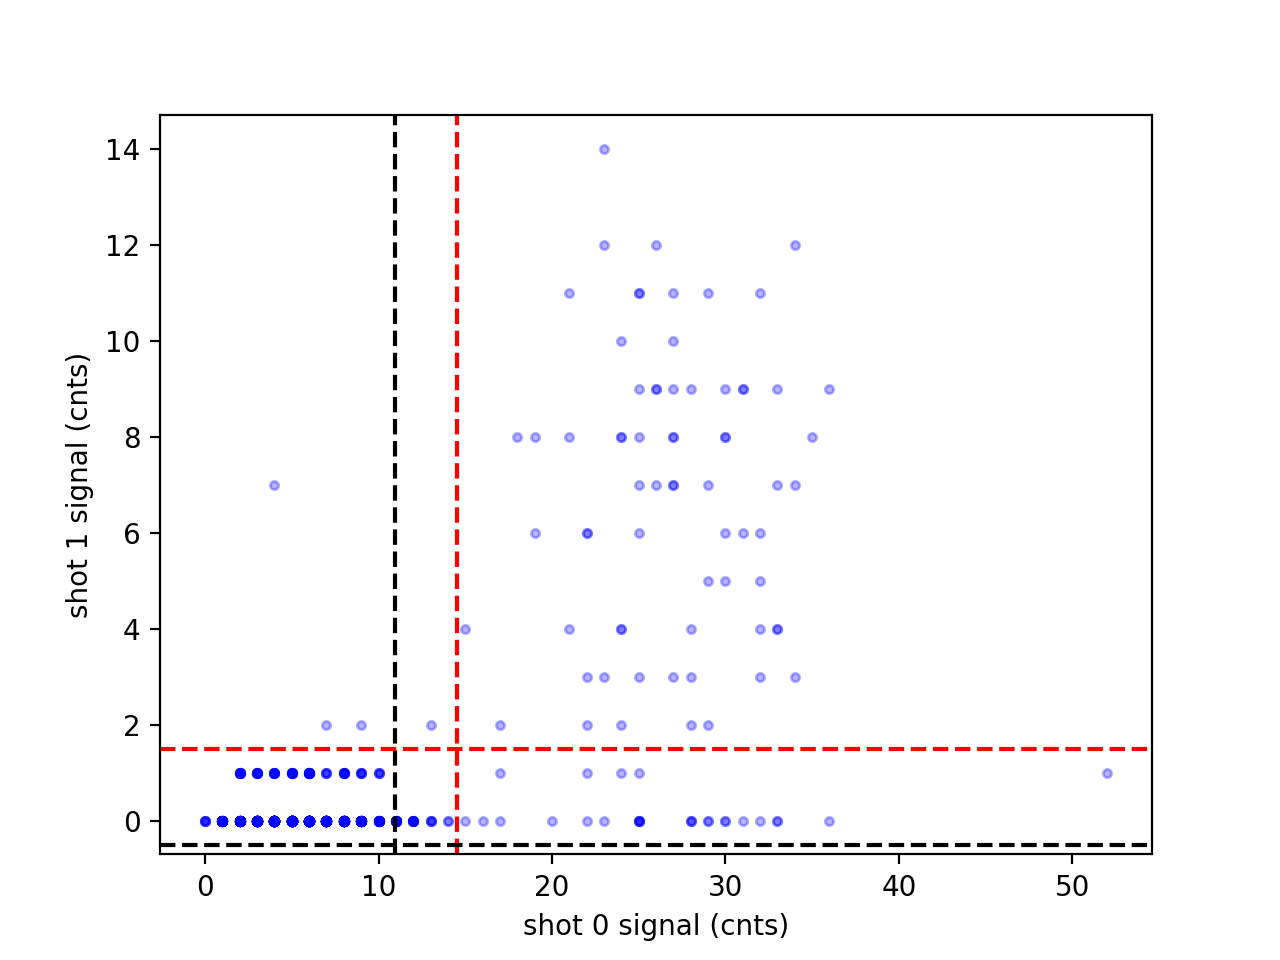

In [486]:
fig, ax = plt.subplots()
s0_data = q.experiments[0]['iterations'][0]['signal_data'][:,0]
s1_data = q.experiments[0]['iterations'][0]['signal_data'][:,1]
ax.plot(s0_data, s1_data, 'b.', alpha=0.3)

for xc in results[0]['cuts']:
    plt.axvline(x=xc-0.5, color='k', linestyle='--')
    plt.axvline(x=cuts[0][0]-0.5, color='r', linestyle='--')
for xc in results[1]['cuts']:
    plt.axhline(y=xc-0.5, color='k', linestyle='--')
    plt.axhline(y=cuts[1][0]-0.5, color='r', linestyle='--')

ax.set_xlabel('shot 0 signal (cnts)')
ax.set_ylabel('shot 1 signal (cnts)')

fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'readout_2d_scatter.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

In [11]:
s1 = np.mean(q.experiments[0]['iterations'][0]['signal_data'][q.experiments[0]['iterations'][0]['quantized_data'][:,0].astype('bool'),0])
s0 = np.mean(q.experiments[0]['iterations'][0]['signal_data'][np.logical_not(q.experiments[0]['iterations'][0]['quantized_data'][:,0]).astype('bool'),0])
print(s0, s1)
print s1 + 2*np.sqrt(s1)

(2.8574821852731591, 24.224899598393574)
34.0686589612


In [128]:
nonss_iter = 0
s1_cut = q.experiments[0]['iterations'][nonss_iter]['signal_data'][q.experiments[0]['iterations'][nonss_iter]['quantized_data'][:,0].astype('bool'),1]
s1_nocut = q.experiments[0]['iterations'][nonss_iter]['signal_data'][np.logical_not(q.experiments[0]['iterations'][nonss_iter]['quantized_data'][:,0].astype('bool')),1]

ss_iter = 1
s1_cut_ss = q.experiments[0]['iterations'][ss_iter]['signal_data'][q.experiments[0]['iterations'][ss_iter]['quantized_data'][:,0].astype('bool'),1]
s1_nocut_ss = q.experiments[0]['iterations'][ss_iter]['signal_data'][np.logical_not(q.experiments[0]['iterations'][ss_iter]['quantized_data'][:,0].astype('bool')),1]

KeyError: 1

<IPython.core.display.Javascript object>


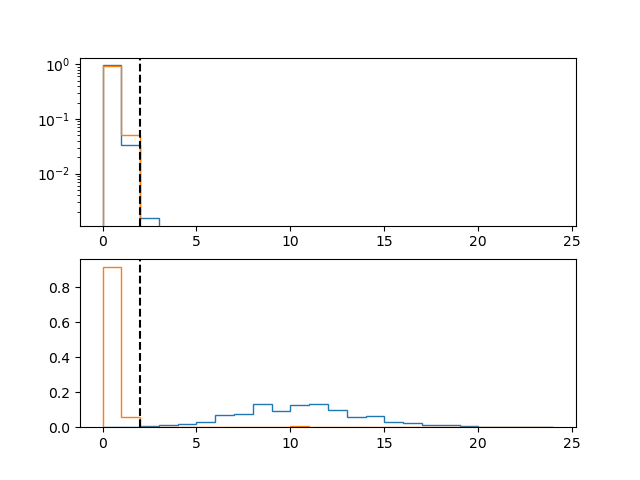

In [260]:
fig, ax = plt.subplots(2)

ax[0].hist(s1_nocut, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')
ax[0].hist(s1_nocut_ss, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')
ax[0].axvline(x=cuts[1][0], color='k', linestyle='--')
ax[0].set_yscale('log', nonposy='clip')
ax[1].hist(s1_cut, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')
ax[1].hist(s1_cut_ss, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')

#ax[1].set_yscale('log', nonposy='clip')
ax[1].axvline(x=cuts[1][0], color='k', linestyle='--')

fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 's1_readout_ss-nonss_comp.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

s1_sig = np.mean(s1_cut)
s1_bg = np.mean(s1_nocut)

In [241]:
s1_sig/np.array([1,0.5])

array([ 10.048,  20.096])

In [242]:
s1_bg/np.array([1,0.5])

array([ 0.0368947 ,  0.07378939])

In [264]:
float(np.sum(s1_nocut > 1))/s1_nocut.shape[0]

0.0015372790161414297

In [262]:
np.sum(s1_nocut_ss > 1)

0